# 一文理解PyTorch:附代码实例 : https://zhuanlan.zhihu.com/p/111144134

## **目录**

- 一个简单的回归问题
- 梯度下降法
- Numpy中的线性回归
- PyTorch
- Autograd
- 动态计算图
- 优化器
- 损失
- 模型
- 数据集
- DataLoader
- 评价

![image-20221213164856675](https://picgo-1306750321.cos.ap-guangzhou.myqcloud.com/image-20221213164856675.png)

## **数据生成**

让我们开始生成一些合成数据:我们从特征x的100个点的向量开始，然后使用a = 1, b = 2和一些高斯噪声创建我们的标签。

接下来，让我们将合成数据分解为**训练集**和**验证集**，打乱索引数组并使用前80个打乱的点进行训练。

In [34]:
import numpy as np

# Data Generation 
np.random.seed(42)
x = np.random.rand(100, 1)
y = 1 + 2 * x + .1 * np.random.randn(100, 1)
# Shuffles the indices
idx = np.arange(100)
np.random.shuffle(idx)
# Uses first 80 random indices for train
train_idx = idx[:80]
# Uses the remaining indices for validation
val_idx = idx[80:]
# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

In [35]:
# Numpy中的线性回归

In [36]:
# Initializes parameters "a" and "b" randomly
np.random.seed(42)
a = np.random.randn(1)
b = np.random.randn(1)

print(a, b)

# Sets learning rate
lr = 1e-1
# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Computes our model's predicted output
    yhat = a + b * x_train

    # How wrong is our model? That's the error!
    error = (y_train - yhat)
    # It is a regression, so it computes mean squared error (MSE)
    loss = (error ** 2).mean()

    # Computes gradients for both "a" and "b" parameters
    a_grad = -2 * error.mean()
    b_grad = -2 * (x_train * error).mean()

    # Updates parameters using gradients and the learning rate
    a = a - lr * a_grad
    b = b - lr * b_grad

print(a, b)

# Sanity Check: do we get the same results as our gradient descent?
from sklearn.linear_model import LinearRegression
linr = LinearRegression()
linr.fit(x_train, y_train)
print(linr.intercept_, linr.coef_[0])

[0.49671415] [-0.1382643]
[1.02354094] [1.96896411]
[1.02354075] [1.96896447]


# torch与numpy 处理 tensor

In [37]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchviz import make_dot

device = 'mps' if torch.backends.mps.is_available() else 'cpu' # use mps on Apple silicon device!


# Our data was in Numpy arrays, but we need to transform them into PyTorch's Tensors
# and then we send them to the chosen device
x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

# Here we can see the difference - notice that .type() is more useful
# since it also tells us WHERE the tensor is (device)
print(type(x_train), type(x_train_tensor), x_train_tensor.type())


<class 'numpy.ndarray'> <class 'torch.Tensor'> torch.mps.FloatTensor


### 动态计算图

In [38]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

yhat = a + b * x_train_tensor
error = y_train_tensor - yhat
loss = (error ** 2).mean()

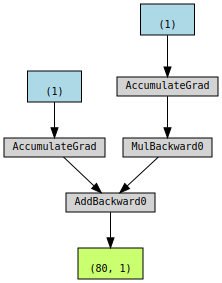

In [39]:
make_dot(yhat)  # Generate dynamic graph


In [40]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

lr = 1e-1
n_epochs = 1000

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD([a, b], lr=lr)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()

    loss.backward()

    # No more manual update!
    # with torch.no_grad():
    #     a -= lr * a.grad
    #     b -= lr * b.grad
    optimizer.step()

    # No more telling PyTorch to let gradients go!
    # a.grad.zero_()
    # b.grad.zero_()
    optimizer.zero_grad()

print(a, b)


tensor([0.2100], device='mps:0', requires_grad=True) tensor([-0.6095], device='mps:0', requires_grad=True)
tensor([1.0235], device='mps:0', requires_grad=True) tensor([1.9690], device='mps:0', requires_grad=True)


### 优化器

到目前为止，我们一直在使用计算出的梯度手动更新参数。这对于两个参数来说可能很好，但是如果我们有很多参数呢?我们使用PyTorch的一个优化器，比如SGD或Adam。

优化器获取我们想要更新的参数、我们想要使用的学习率(可能还有许多其他超参数!)并通过其step()方法执行更新。

此外，我们也不需要一个接一个地将梯度归零。我们只需调用优化器的`zero_grad()`方法就可以了! 在下面的代码中，我们创建了一个随机梯度下降(SGD)优化器来更新参数a和b。

> 不要被优化器的名字所欺骗:如果我们一次使用所有的训练数据进行更新——就像我们在代码中所做的那样——优化器执行的是批量梯度下降，而不是它的名字。

In [41]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

lr = 1e-1
n_epochs = 1000

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD([a, b], lr=lr)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()

    loss.backward()    
    
    # No more manual update!
    # with torch.no_grad():
    #     a -= lr * a.grad
    #     b -= lr * b.grad
    optimizer.step()
    
    # No more telling PyTorch to let gradients go!
    # a.grad.zero_()
    # b.grad.zero_()
    optimizer.zero_grad()
    
print(a, b)

tensor([-0.3291], device='mps:0', requires_grad=True) tensor([0.2336], device='mps:0', requires_grad=True)
tensor([1.0235], device='mps:0', requires_grad=True) tensor([1.9690], device='mps:0', requires_grad=True)
